# Transfer Learning with Med MNIST.

In this assignment you will use transfer learning to train a model of your choice on a sub-dataset from the [MedMNIST datasets](https://medmnist.com/). ![](https://github.com/tonyscan6003/etivities/blob/main/medmnist.JPG?raw=true)

* The [MedMNIST package](https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb) allows the data to be imported directly as a pytorch dataset.

* You may select any of the datasets using Multi-class/binary classification. The goal is to acheve accuracy levels comparable to the benchmark results shown on the medmnist site. Dataloading for pytorch is setup in the notebook, you wil need to modify the code slightly depending on your dataset of choice.

* Some datasets use black and white images, so you will need to [at least concatenate](https://towardsdatascience.com/transfer-learning-on-greyscale-images-how-to-fine-tune-pretrained-models-on-black-and-white-9a5150755c7a) the input image channels (to 3 channels) for compatibility with the models pre-trained on imageNet.

* Some of the MedMNIST datasets don't contain too much data so Data augmentation may be essentila essential to avoid overfitting. In pytorch data augmentation is performed using the [transforms.v2](https://pytorch.org/vision/main/transforms.html) modules.

* In this notebook: You will need to import a model, and perform training. Tranfer Learning for computer vision is detailed [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

* [Tensorboard can be imported](https://pytorch.org/tutorials/beginner/introyt/tensorboardyt_tutorial.html) to display results.

* Please only include one example of transfer learning in the submitted notebook. Making sure training curves/results are clearly visible. If you have trained additional transfer learning models (i.e. that were less successful) please add this as a table or report at the end of the notebook and/or in your final forum post.




# 1. Install & Import Packages

In [1]:
#!pip install medmnist
#!pip install torchinfo

In [2]:
import torch
from torch import nn
from torchvision import datasets, models
from torchvision.transforms import ToTensor, v2, Pad, Grayscale
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

## 2. Setup & Import Dataset
The [MedMNSIT](https://medmnist.com/) package (imported above) makes available several medical datasets available to access.

You can change the `data_flag` variable (dataset names are all lower case letters) to the dataset of your choice (Take care to note the parameters e.g. number of input channels below that will affect your model)



In [3]:
import medmnist
from medmnist import INFO, Evaluator

data_flag = 'pathmnist'
download = True

BATCH_SIZE = 64

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

print('Type of Machine Learning Task = ',task)
print('Number of Input Data Channels = ',n_channels)
print('Number of Classes = ',n_classes)
print('The batch size for this dataset will be = ',BATCH_SIZE)

DataClass = getattr(medmnist, info['python_class'])

Type of Machine Learning Task =  multi-class
Number of Input Data Channels =  3
Number of Classes =  9
The batch size for this dataset will be =  64


Transforms:
You can update the functions below with appropriate transforms for your particular use case.

* As well as being suitable for data augmention for image classification, the transforms.v2 package of torchvision extends transforms for object detection and segmentation tasks. An illustration of the transforms is shown [here](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py).
* Normalisation based on ImageNet parameters is included already. This should be used with all models pre-trained on ImageNet  





In [4]:

train_transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    ToTensor(),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


test_transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    ToTensor(),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

Setup your Medmnist dataset.
* The convolution part of pre-trained networks (such as resnet) are compatable with any size input image. However they were trained on 224 x 224 size images, with early layers finding small scale features and deeper layers finding large scale features.
* For this transfer learning application to medical data, the gap between the original ImageNet domain and the medical images is wide. Therefore the size/scale of the input images is less important, however in general we would expect better performance with the larger input images (as they contain more features at different scales).
* You can add the `size=224` parameter to the dataset object calls, to load full size images. Only do this once you are confident in your training methodology (or if the dataset is small), as training with full size images will take longer.


In [5]:
# Download training data from open datasets.
train_dataset = DataClass(split='train', transform=train_transforms, download=download, size=224, mmap_mode='r')
test_dataset = DataClass(split='test', transform=test_transforms, download=download, size=224, mmap_mode='r')
val_dataset = DataClass(split='val', transform=test_transforms, download=download, size=224, mmap_mode='r')


The `Dataset` is passed as an argument to `DataLoader`. This wraps an
iterable over the dataset, and supports automatic batching, sampling,
shuffling and multiprocess data loading.

In [6]:
# Create data loaders.
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64, 1]) torch.int64


Plot some example augmented images

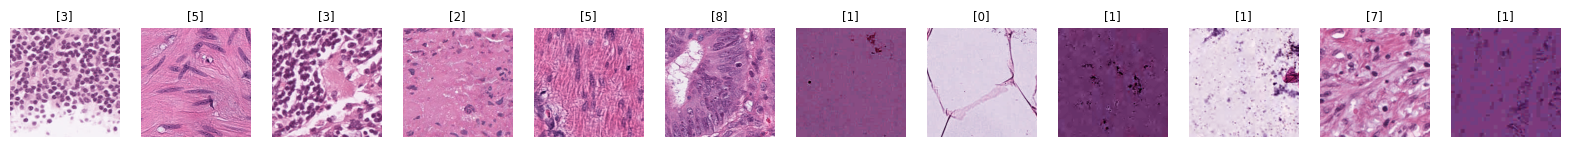

In [7]:
# Output next batch from dataloader
dataiter = iter(train_dataloader)
image_batch, labels_batch = next(dataiter)

# Use matplotlib to plot a sample of images

i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

for image in image_batch[0:n_plots,:,:,:]:
  disp_image =  torch.permute(image,(2,1,0)).numpy() # return image to cpu for display and permute to channels last
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  disp_image = std * disp_image + mean
  disp_image = np.clip(disp_image, 0, 1)
  axarr[i].imshow(disp_image[:,:,:])
  axarr[i].axis("off")
  axarr[i].set_title(labels_batch[i].numpy(),fontsize='small')
  i = i+1


# 3. Define Transfer Learning model
Pytorch has an inbuilt [models package](https://pytorch.org/vision/stable/models.html) that allows loading of popular models with pre-trained weights.

* We want to add an additional classifier stage (to the output of the network). How to setup the [model is detailed here](https://discuss.pytorch.org/t/load-only-a-part-of-the-network-with-pretrained-weights/88397/2).
* This additional classifier may just be a single layer or a cascade of fully connected layers with dropout.
* Note that the number of parameters in the convolutional part of the model will be same no what the input size is set to. However the output feature map size will vary with input image size (small for small image, large for large image). This means the number of parameters in the additional classifier will change depending on input image size.


In [8]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [9]:
import torchvision
from torchinfo import summary


In [10]:
pretrained = torchvision.models.resnet18(weights=True)
class pathMedMNIST_Classifier(nn.Module):
    def __init__(self, my_pretrained_model, num_classes=9):
        super(pathMedMNIST_Classifier, self).__init__()
        self.weights = my_pretrained_model

        for param in self.weights.parameters():
            param.requires_grad=False

        in_features = self.weights.fc.in_features
        self.weights.fc = nn.Sequential(
            nn.Linear(in_features, 100),
            nn.ReLU(),
            #nn.Dropout(p=0.5),
            nn.Linear(100, num_classes)
        )
    
    def forward(self, x):
        x = self.weights(x)
        return x

my_extended_model = pathMedMNIST_Classifier(my_pretrained_model=pretrained, num_classes = 9)
print(summary(my_extended_model, input_size=(BATCH_SIZE, 3, 28, 28)))

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = total_params - trainable_params
    
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Frozen parameters: {frozen_params:,}")


count_parameters(my_extended_model)


C:\Users\cianm\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                        Output Shape              Param #
pathMedMNIST_Classifier                       [64, 9]                   --
├─ResNet: 1-1                                 [64, 9]                   --
│    └─Conv2d: 2-1                            [64, 64, 14, 14]          (9,408)
│    └─BatchNorm2d: 2-2                       [64, 64, 14, 14]          (128)
│    └─ReLU: 2-3                              [64, 64, 14, 14]          --
│    └─MaxPool2d: 2-4                         [64, 64, 7, 7]            --
│    └─Sequential: 2-5                        [64, 64, 7, 7]            --
│    │    └─BasicBlock: 3-1                   [64, 64, 7, 7]            (73,984)
│    │    └─BasicBlock: 3-2                   [64, 64, 7, 7]            (73,984)
│    └─Sequential: 2-6                        [64, 128, 4, 4]           --
│    │    └─BasicBlock: 3-3                   [64, 128, 4, 4]           (230,144)
│    │    └─BasicBlock: 3-4                   [64, 128, 4, 4]       

# 4. Optimisation & Training Loop

Define a training loop that prints the loss from the training and validation set at least every epoch.
* You may choose to make the validation loss calculations more frequent so you can ensure training is progressing satisfactorily (especially with larger datasets).

* You can use tensorboard to visualise the [loss curves](https://pytorch.org/docs/stable/tensorboard.html))

* For multi-class classification classification problem we will use the  [CrossEntropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). In this pytorch function, the input is the un-normalised logit value.

* You may  have to use [torch.squeeze](https://pytorch.org/docs/stable/generated/torch.squeeze.html) to reduce the dimensionality of the label tensor before passing it to the loss function (this due to how the dataset is configured and the loss will only accept 0D or 1D inputs)

In [11]:
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
writer = SummaryWriter('runs')

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(my_extended_model.parameters(), lr=0.001)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
my_extended_model = my_extended_model.to(device)

# Basic loop
num_epochs = 20  # you can increase this later

for epoch in tqdm(range(num_epochs)):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 20)
    
    # ---- TRAINING PHASE ----
    my_extended_model.train()  # set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = torch.squeeze(labels)  # make sure labels are 1D
        
        optimizer.zero_grad()           # clear old gradients
        outputs = my_extended_model(inputs)  # forward pass
        loss = criterion(outputs, labels)    # compute loss
        loss.backward()                     # backpropagation
        optimizer.step()                    # update weights
        
        running_loss += loss.item()
        
        # --- Track training accuracy ---
        _, preds = torch.max(outputs, 1)
        correct_train += torch.sum(preds == labels)
        total_train += labels.size(0)
    
    train_loss = running_loss / len(train_dataloader)
    train_acc = correct_train.double() / total_train
    print(f"Training Loss: {train_loss:.4f} | Training Accuracy: {train_acc:.4f}")
    
    # ---- VALIDATION PHASE ----
    my_extended_model.eval()  # set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # no gradient calculation in validation
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = torch.squeeze(labels)
            
            outputs = my_extended_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels)
            total += labels.size(0)
    
    val_loss = val_loss / len(val_dataloader)
    val_acc = correct.double() / total
    
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")
        # ---- TENSORBOARD LOGGING ----
    
    writer.add_scalars(
        'Loss',
        {'Training Loss': train_loss, 'Validation Loss': val_loss},
        epoch
    )
    writer.add_scalars(
        'Accuracy',
        {'Training Acc': train_acc, 'Validation Acc': val_acc},
        epoch
)

writer.close()


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1/20
--------------------
Training Loss: 0.2343 | Training Accuracy: 0.9260
Validation Loss: 0.1267 | Validation Accuracy: 0.9574

Epoch 2/20
--------------------
Training Loss: 0.1504 | Training Accuracy: 0.9507
Validation Loss: 0.1054 | Validation Accuracy: 0.9639

Epoch 3/20
--------------------
Training Loss: 0.1251 | Training Accuracy: 0.9583
Validation Loss: 0.1060 | Validation Accuracy: 0.9661

Epoch 4/20
--------------------
Training Loss: 0.1111 | Training Accuracy: 0.9621
Validation Loss: 0.0811 | Validation Accuracy: 0.9731

Epoch 5/20
--------------------
Training Loss: 0.1001 | Training Accuracy: 0.9670
Validation Loss: 0.0799 | Validation Accuracy: 0.9737

Epoch 6/20
--------------------
Training Loss: 0.0903 | Training Accuracy: 0.9701
Validation Loss: 0.0769 | Validation Accuracy: 0.9751

Epoch 7/20
--------------------
Training Loss: 0.0847 | Training Accuracy: 0.9710
Validation Loss: 0.0742 | Validation Accuracy: 0.9769

Epoch 8/20
--------------------
Training

Initialise Tensorboard (use of tensorboard in colab notebooks is [detailed here](https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tensorboard_in_notebooks.ipynb)). A [Pytorch tutorial](https://pytorch.org/tutorials/beginner/introyt/tensorboardyt_tutorial.html) shows how to setup the training and validation loop with pytorch.


In [13]:
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir runs --bind_all

Reusing TensorBoard on port 6006 (pid 12492), started 1:56:26 ago. (Use '!kill 12492' to kill it.)

# 5. Evaluate Model
You will need to setup an evaluation loop for the model to assess it's performance on the test dataset.

You may also obtain a classification report after final evaluation of the test dataset with the model using the code below. A confusion matrix can also be obtained and we will plot a few example images.



In [14]:
import numpy as np

my_extended_model.eval()
store_predictions = []
store_labels = []

classes = [
    "1 - adipose",
    "2 - background",
    "3 - debris",
    "4 - lymphocytes",
    "5 - mucus",
    "6 - smooth muscle",
    "7 - normal colon mucosa",
    "8 - cancer-associated stroma",
    "9 - colorectal adenocarcinoma epithelium"
]

with torch.no_grad():
    for input_batch, label_batch in test_dataloader:
        input_batch = input_batch.to(device)
        label_batch = label_batch.to(device)
        
        pred_logit = my_extended_model(input_batch)
        predictions = torch.argmax(pred_logit, dim=1)
        
        store_predictions.append(predictions.cpu().numpy())
        store_labels.append(label_batch.cpu().numpy())

# concatenate all batches into 1D arrays
y_pred = np.concatenate(store_predictions)
y_true = np.concatenate(store_labels)

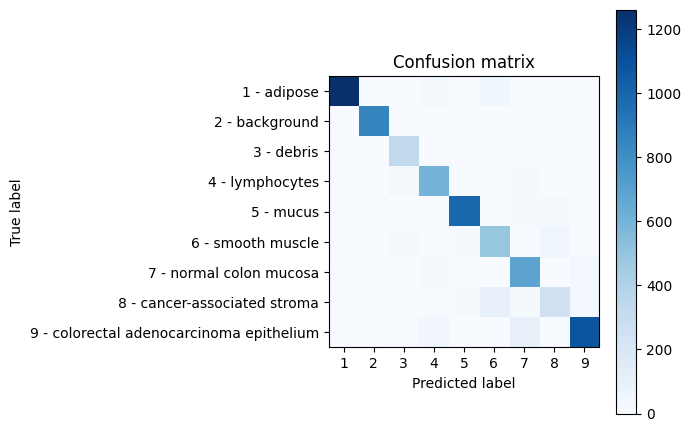

In [15]:
#https://scikit-learn.org/0.16/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, range(1,10))
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=classes))

                                          precision    recall  f1-score   support

                             1 - adipose       0.99      0.94      0.97      1338
                          2 - background       0.99      1.00      0.99       847
                              3 - debris       0.86      0.98      0.92       339
                         4 - lymphocytes       0.86      0.94      0.90       634
                               5 - mucus       0.96      0.96      0.96      1035
                       6 - smooth muscle       0.77      0.84      0.80       592
                 7 - normal colon mucosa       0.84      0.92      0.88       741
            8 - cancer-associated stroma       0.77      0.59      0.67       421
9 - colorectal adenocarcinoma epithelium       0.93      0.88      0.91      1233

                                accuracy                           0.91      7180
                               macro avg       0.89      0.90      0.89      7180
              

 # Comments about your Approach

 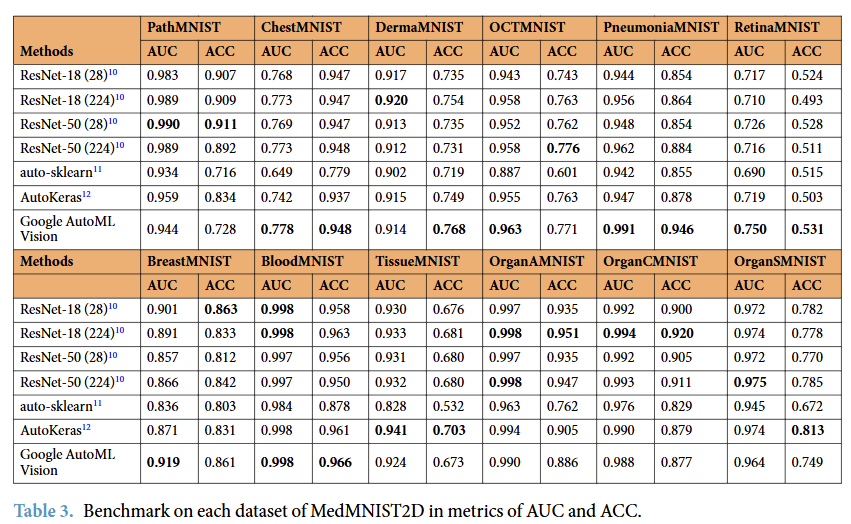